<a name="Imports-and-Logging-Configuration"></a>1. Imports and Logging Configuration
First, import all necessary libraries and configure the logging mechanism to monitor the training process.

In [20]:
# Imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, floor
from skimage.transform import resize
import seaborn as sns
import logging
import time

# Qiskit Imports
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import Parameter, ParameterVector
from qiskit.primitives import Sampler
from qiskit_algorithms.optimizers import COBYLA, SPSA 
from qiskit_machine_learning.algorithms import VQC
from qiskit.circuit.library import TwoLocal

# Logging Configuration
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),  # Output to console
        logging.FileHandler('vqc_training.log', mode='w')  # Output to file
    ]
)

# Create a logger instance
logger = logging.getLogger('VQC_Training')


<a name="Utility-Functions"></a>2. Utility Functions
Define utility functions that assist in data preprocessing and visualization.

In [21]:
def largest_perfect_square(num_qubits):
    """Finds the largest perfect square less than or equal to num_qubits."""
    sqrt_val = floor(sqrt(num_qubits))
    return sqrt_val ** 2


def downscale_image(image, num_qubits):
    """
    Downscale the image to fit the number of qubits using block averaging.
    
    Parameters:
    - image (array): Flattened image array.
    - num_qubits (int): Number of qubits.
    
    Returns:
    - downscaled_image (array): Flattened downscaled image.
    - valid_qubits (int): Adjusted number of qubits.
    """
    original_size = 28  # MNIST images are 28x28

    # Find the largest perfect square less than or equal to num_qubits
    valid_qubits = largest_perfect_square(num_qubits)

    # Determine the new size for downscaling
    new_size = int(sqrt(valid_qubits))
    if new_size == 0:
        raise ValueError("Number of qubits is too small to downscale the image.")

    # Reshape the image to 2D
    try:
        image_2d = image.reshape(original_size, original_size)
    except ValueError as e:
        raise ValueError(f"Error reshaping image: {e}")

    # Calculate the factor by which to downscale
    factor = original_size // new_size
    if original_size % new_size != 0:
        # To handle cases where original_size is not perfectly divisible by new_size
        factor += 1

    # Initialize the downscaled image
    downscaled_image = np.zeros((new_size, new_size))

    # Perform block averaging
    for i in range(new_size):
        for j in range(new_size):
            # Define the boundaries of the current block
            start_i = i * factor
            end_i = start_i + factor
            start_j = j * factor
            end_j = start_j + factor

            # Extract the block and compute the average
            block = image_2d[start_i:end_i, start_j:end_j]
            downscaled_image[i, j] = block.mean()

    return downscaled_image.flatten(), valid_qubits



def display_comparisons(X_scaled, X_downscaled, y_subset, num_images, new_size):
    """
    Display original and downscaled images side by side.

    Parameters:
    - X_scaled (array): Original scaled images.
    - X_downscaled (array): Downscaled images.
    - y_subset (array): Labels.
    - num_images (int): Number of images to display.
    - new_size (int): Size of downscaled images.
    """
    for i in range(num_images):
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        
        # Show original image
        axes[0].imshow(X_scaled[i].reshape(28, 28), cmap='gray')
        axes[0].set_title(f"Original Image (28x28)\nLabel: {y_subset[i]}")
        axes[0].axis('off')
        
        # Show downscaled image
        axes[1].imshow(X_downscaled[i].reshape(new_size, new_size), cmap='gray')
        axes[1].set_title(f"Downscaled Image ({new_size}x{new_size})\nLabel: {y_subset[i]}")
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()



<a name="Callback-Logger-Class"></a>5. Callback Logger Class
Define a callback class to log the optimizer's progress during training.

In [22]:
class CallbackLogger:
    def __init__(self, logger):
        self.logger = logger
        self.iteration = 0
        self.param_history = []
        self.fval_history = []
        self.stepsize_history = []
    
    def __call__(self, *args, **kwargs):
        """
        Callback function to log optimizer progress.

        Parameters:
        - *args: Variable length argument list.
        - **kwargs: Arbitrary keyword arguments.
        """
        self.iteration += 1

        # Attempt to extract known parameters from args or kwargs
        # Adjust this based on the actual arguments passed by the optimizer
        if len(args) >= 1:
            xk = args[0]
            self.param_history.append(xk)
            self.logger.info(f"Iteration {self.iteration}: Parameters: {xk}")
        
        if len(args) >= 2:
            fval = args[1]
            self.fval_history.append(fval)
            self.logger.info(f"Iteration {self.iteration}: Function value: {fval}")
        
        if len(args) >= 3:
            stepsize = args[2]
            self.stepsize_history.append(stepsize)
            self.logger.info(f"Iteration {self.iteration}: Step size: {stepsize}")
        
        # Handle any additional keyword arguments
        if kwargs:
            self.logger.info(f"Iteration {self.iteration}: Additional info: {kwargs}")


<a name="Quantum-Circuit-Definitions"></a>6. Quantum Circuit Definitions
Define quantum circuits for feature encoding and the parameterized ansatz.

In [23]:
def parameterized_scaled_angle_encoding(num_qubits, scale_factor=np.pi):
    """
    Parameterized Angle Encoding with Feature Scaling.

    Parameters:
    - num_qubits (int): Number of qubits in the circuit.
    - scale_factor (float): Scaling factor to adjust rotation angles.

    Returns:
    - QuantumCircuit: Parameterized quantum circuit implementing scaled angle encoding.
    """
    qr = QuantumRegister(num_qubits, name='q')
    circuit = QuantumCircuit(qr)
    data_parameters = ParameterVector('x', num_qubits)
    for i in range(num_qubits):
        angle = data_parameters[i] * scale_factor
        circuit.ry(angle, qr[i])
    return circuit


def parameterized_ansatz(num_qubits, parameters):
    """
    Parameterized Ansatz.

    Constructs a Parameterized Quantum Circuit (PQC) with RY and RZ gates and entangling CX gates.

    Parameters:
    - num_qubits (int): Number of qubits in the circuit.
    - parameters (ParameterVector): List of parameters for rotation gates.

    Returns:
    - QuantumCircuit: Parameterized quantum circuit implementing the ansatz.
    """
    qr = QuantumRegister(num_qubits, name='q')
    circuit = QuantumCircuit(qr)
    param_idx = 0
    for i in range(num_qubits):
        circuit.ry(parameters[param_idx], qr[i])
        param_idx += 1
        circuit.rz(parameters[param_idx], qr[i])
        param_idx += 1
    # Entangling layer
    for i in range(num_qubits - 1):
        circuit.cx(qr[i], qr[i + 1])
    return circuit


<a name="Data-Preprocessing"></a>7. Data Preprocessing

2024-09-28 19:09:02,808 - INFO - Loading MNIST dataset...
2024-09-28 19:09:11,175 - INFO - Subset size: 200 samples
2024-09-28 19:09:11,176 - INFO - Scaling pixel values...
2024-09-28 19:09:11,180 - INFO - Number of qubits set to 9
2024-09-28 19:09:11,181 - INFO - Downscaling images to fit 9 qubits...
2024-09-28 19:09:11,200 - INFO - Splitting dataset into training and testing sets...
2024-09-28 19:09:11,203 - INFO - Training set size: 160 samples
2024-09-28 19:09:11,204 - INFO - Testing set size: 40 samples
2024-09-28 19:09:11,205 - INFO - Displaying class distribution in the subset...
2024-09-28 19:09:11,226 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-28 19:09:11,236 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the

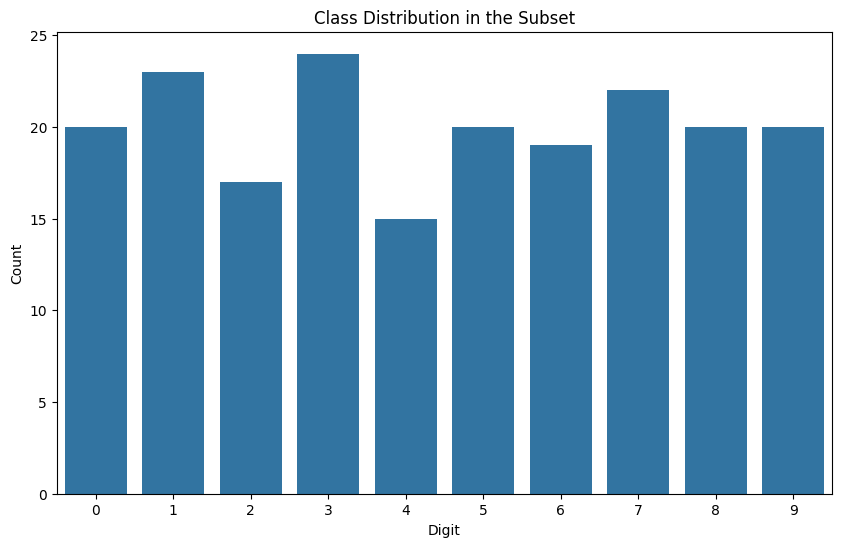

2024-09-28 19:09:11,446 - INFO - Displaying comparisons for the first 5 images...


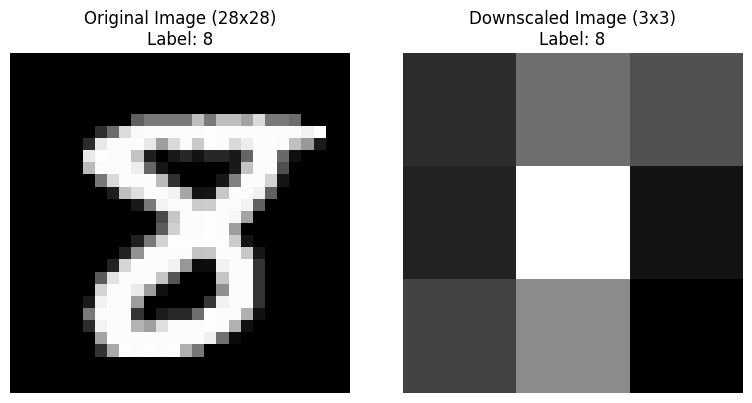

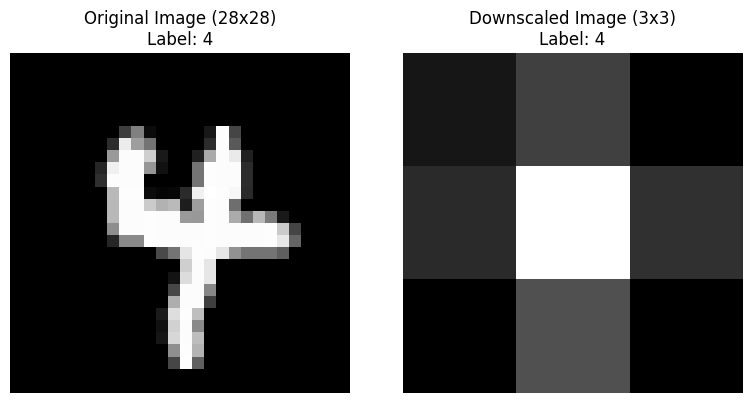

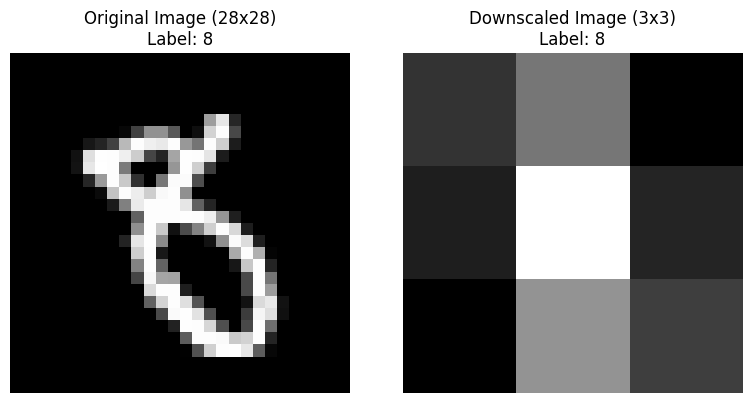

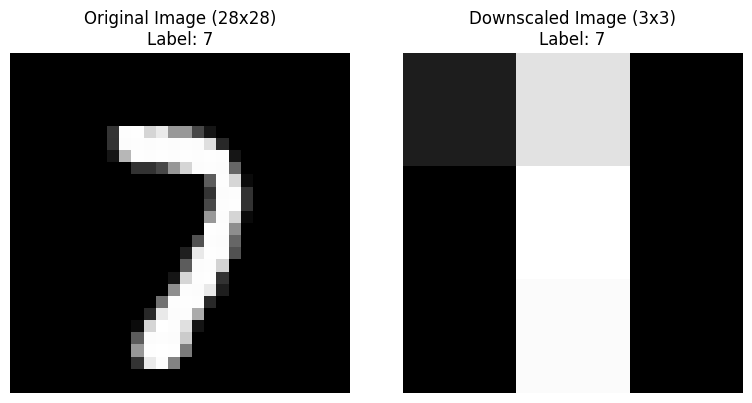

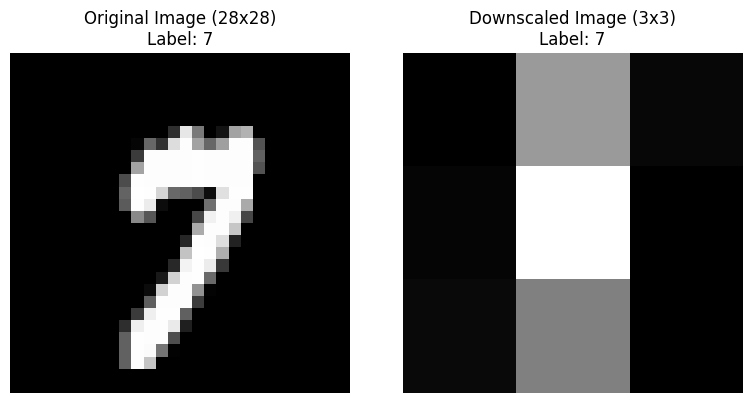

In [24]:
# Data Preprocessing
try:
    # Load MNIST dataset
    logger.info("Loading MNIST dataset...")
    mnist = fetch_openml('mnist_784', version=1, as_frame=False)
    X = mnist.data
    y = mnist.target.astype(int)
    
    # Shuffle the dataset to ensure a random distribution of classes
    X, y = shuffle(X, y, random_state=42)
    
    # Subset the dataset for faster execution (e.g., 500 images)
    subset_size = 200  # Adjust as needed
    X_subset = X[:subset_size]
    y_subset = y[:subset_size]
    logger.info(f"Subset size: {subset_size} samples")
    
    # Normalize pixel values to [0, 1]
    logger.info("Scaling pixel values...")
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_subset)
    
    # Define the number of qubits
    num_qubits = 9  # Adjust as needed
    
    # Check and warn only once if the number of qubits isn't a perfect square
    valid_qubits = largest_perfect_square(num_qubits)
    if valid_qubits != num_qubits:
        logger.warning(f"{num_qubits} qubits is not a perfect square. Using {valid_qubits} qubits instead.")
        num_qubits = valid_qubits
    else:
        logger.info(f"Number of qubits set to {num_qubits}")
    
    # Apply the enhanced downscale_image function to the dataset
    logger.info(f"Downscaling images to fit {num_qubits} qubits...")
    X_downscaled = np.array([downscale_image(img, num_qubits)[0] for img in X_scaled])
    new_size = int(sqrt(valid_qubits))
    
    # Split the dataset into training and testing sets
    logger.info("Splitting dataset into training and testing sets...")
    X_train, X_test, y_train, y_test = train_test_split(
        X_downscaled, y_subset, test_size=0.2, random_state=42, stratify=y_subset
    )
    logger.info(f"Training set size: {X_train.shape[0]} samples")
    logger.info(f"Testing set size: {X_test.shape[0]} samples")
    
    # Display the distribution of classes in the subset
    logger.info("Displaying class distribution in the subset...")
    plt.figure(figsize=(10, 6))
    sns.countplot(x=y_subset)
    plt.title("Class Distribution in the Subset")
    plt.xlabel("Digit")
    plt.ylabel("Count")
    plt.show()
    
    # Display the comparisons for a few images
    num_images_to_display = 5
    logger.info(f"Displaying comparisons for the first {num_images_to_display} images...")
    display_comparisons(X_scaled, X_downscaled, y_subset, num_images_to_display, new_size)
    
except Exception as e:
    logger.critical(f"An error occurred during data preprocessing: {e}")


<a name="Quantum-Machine-Learning-Setup"></a>8. Quantum Machine Learning Setup

a. Instantiate Callback Logger

In [25]:
# Instantiate the callback logger
callback_logger = CallbackLogger(logger)


b. Define Feature Map and Ansatz

In [26]:
# Define the feature map and ansatz
feature_map = parameterized_scaled_angle_encoding(num_qubits)
logger.info("Feature map created using parameterized_scaled_angle_encoding")

ansatz_parameters = ParameterVector('θ', 2 * num_qubits)
ansatz = parameterized_ansatz(num_qubits=num_qubits, parameters=ansatz_parameters)
logger.info("Ansatz created using parameterized_ansatz")


2024-09-28 19:09:18,500 - INFO - Feature map created using parameterized_scaled_angle_encoding
2024-09-28 19:09:18,502 - INFO - Ansatz created using parameterized_ansatz


c. Initialize Sampler

In [27]:
# Initialize the sampler
sampler = Sampler()
logger.info("Sampler initialized")

/var/folders/1t/dx5zswn17y58r7kqkt5gw0nm0000gn/T/ipykernel_13690/4191440393.py:2: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
2024-09-28 19:09:20,417 - INFO - Sampler initialized


d. Initialize Optimizer with Callback

In [28]:
# Initialize the optimizer with the callback
optimizer = COBYLA(maxiter=100, tol=0.01)  # You can change the optimizer here
logger.info("Optimizer initialized: COBYLA with maxiter=100 and tol=0.01")


2024-09-28 19:09:21,689 - INFO - Optimizer initialized: COBYLA with maxiter=100 and tol=0.01


f. Define the VQC Model

In [29]:
# Define the VQC with feature map, ansatz, optimizer, and sampler
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    sampler=sampler
)
logger.info("VQC model initialized")


2024-09-28 19:09:23,232 - INFO - VQC model initialized


<a name="Model-Training"></a>9. Model Training

In [30]:
# Convert training and testing data to NumPy arrays
X_train_np = np.array(X_train)
y_train_np = np.array(y_train).flatten()
X_test_np = np.array(X_test)
y_test_np = np.array(y_test).flatten()

logger.info("Data preprocessing completed.")

# Track the start time
start_time = time.time()
logger.info("Training started")

try:
    # Train the VQC
    vqc.fit(X_train_np, y_train_np)
    logger.info("Training completed")
except Exception as e:
    logger.error(f"An error occurred during training: {e}")
    vqc = None  # Ensure VQC is set to None if training fails

# Track the end time
end_time = time.time()
duration = end_time - start_time
logger.info(f"Training duration: {duration:.2f} seconds")


2024-09-28 19:09:25,146 - INFO - Data preprocessing completed.
2024-09-28 19:09:25,148 - INFO - Training started
2024-09-28 19:12:11,297 - INFO - Training completed
2024-09-28 19:12:11,298 - INFO - Training duration: 166.15 seconds


In [31]:
if vqc is not None:
    try:
        # Predict on the test set
        y_pred = vqc.predict(X_test_np)
        logger.info("Prediction on test set completed")
        
        # Evaluate the model
        accuracy = accuracy_score(y_test_np, y_pred)
        logger.info(f"Test Accuracy: {accuracy * 100:.2f}%")
        
        # Additional Evaluation Metrics
        classification_rep = classification_report(y_test_np, y_pred)
        conf_matrix = confusion_matrix(y_test_np, y_pred)
        
        logger.info(f"Classification Report:\n{classification_rep}")
        logger.info(f"Confusion Matrix:\n{conf_matrix}")
        
        # Save the parameter history to a file
        with open('parameter_history.txt', 'w') as f:
            for idx, params in enumerate(callback_logger.param_history, 1):
                f.write(f"Iteration {idx}: {params}\n")
        logger.info("Parameter history saved to parameter_history.txt")
        
        # Save additional metrics
        with open('classification_report.txt', 'w') as f:
            f.write(classification_rep)
        logger.info("Classification report saved to classification_report.txt")
        
        np.savetxt('confusion_matrix.csv', conf_matrix, delimiter=',', fmt='%d')
        logger.info("Confusion matrix saved to confusion_matrix.csv")
        
    except Exception as e:
        logger.error(f"An error occurred during prediction or evaluation: {e}")
else:
    logger.error("VQC training failed. Skipping evaluation steps.")


2024-09-28 19:12:14,738 - INFO - Prediction on test set completed
2024-09-28 19:12:14,739 - INFO - Test Accuracy: 12.50%
/Users/danielkolesnik/Desktop/Physics/TUM/2_Semester/Computational methods of many body physics/quantum_ml_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/danielkolesnik/Desktop/Physics/TUM/2_Semester/Computational methods of many body physics/quantum_ml_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/danielkolesnik/Desktop/Physics/TUM/2_S